# Multiple linear regression
## Introduction
In this notebook I present a linear regression on five variables using gradient descent and the normal equation. The data come a built-in data set of R called *state.x77* and containing socio-economic data for US states. The data are a bit old as they were collected during the 70s, but more recent data can be found on the website of the [United States Census Bureau](https://www.census.gov/en.html). We will perform the linear regression using gradient descent or the normal equation.
## Data import and visualization
First, let's load the modules we will need for this analysis. Pandas is useful to store data in a data frame, Numpy is used to carry out the computations, and Matplotlib will plot the data.
I exported a *comma separated value* (csv) file from R, representing a subset of the original data set. This file contains only the variables we are interested in for now: per capita income, the percentage of illiteracy, the murder rate (per 100,000), the percentage of high school graduates and life expectancy.
The data is imported in a Pandas DataFrame, then we plot variables in pairs to visually check for a correlation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import data from file
data = pd.read_csv("state-x77-small.csv")
#remove the first column wich is an irrelevant index
data = data[data.columns[1:]]

#plot variables by pair, the first column is ignored as it contains state names
ax = pd.plotting.scatter_matrix(data[1:])
plt.show()

The scatter_matrix function proposed by Pandas is a bit rough but it looks decent if not too many variables are plotted. Let's say we want to predict life expectancy (the target) from the other variables (the features). By eye, we can spot a correlation between our target, and the *high school graduates* and *murder* features. For the other features, the correlation seems less clear. We will perform a linear regression using multiple features, in order to predict the life expectancy. Let's first define the functions we need for this: the cost function used in the gradient descent, and the normal equation function.

In [2]:
#definition of the cost function
def cost(X, Y, theta):
    """Return the mean squared error based on input matrix X, output vector Y, and linear model
    parameters theta"""
    return np.sum((np.dot(X, theta) - Y) ** 2) / 2 / len(Y)

def gradient_descent(X, Y, theta, alpha, n_iter):
    """Return learned parameters theta of linear model as calculated by gradient descent using
    input matrix X, output matrix Y, initial parameters theta, learning rate alpha and
    number of iteration n_iter"""
    #define matrix to store cost history
    cost_history = np.zeros(n_iter)
    #loop for n_iter iterations to perform gradient descent
    for i in range(n_iter):
        delta = np.dot(X.T, (np.dot(X, theta) - Y)) / len(Y) #derivative of cost function
        theta -= alpha * delta
        cost_history[i] = cost(X, Y, theta)
    return theta, cost_history

def norm_eq(X, Y):
    """Return linear regression parameters theta for X and Y by using the normal equation."""
    return np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Y)

We first generate a matrix X containing all the input data. We have 50 states and 4 features so we have a 50 x 4 matrix. We do the same for the output (target) data and we obtain a 50 x 1 vector.

In [3]:
#generate input matrix (the features used for prediction)
X = np.array(data[data.columns[1]][:, np.newaxis])
for i in range(2, len(data.columns) - 1):
    X = np.concatenate((X, data[data.columns[i]][:, np.newaxis]), axis=1)
    
#generate output vector (the variable we would like to predict)
Y = np.array(data['Life Exp'][:, np.newaxis])

## Gradient descent
Let's have a look at the first few rows of data to have a sense of the scale of the data. You can also have a look at the axes on the pair-wise plot above.

In [4]:
data.head()

,state,Income,Illiteracy,Murder,HS Grad,Life Exp
0,Alabama,3624,2.1,15.1,41.3,69.05
1,Alaska,6315,1.5,11.3,66.7,69.31
2,Arizona,4530,1.8,7.8,58.1,70.55
3,Arkansas,3378,1.9,10.1,39.9,70.66
4,California,5114,1.1,10.3,62.6,71.71


 The features span three orders of magnitude, so it makes sens to normalize the data by subtracting the mean and dividing by the standard deviation for each feature element. After normalization we can add a column of *1* to the input, to perform vectorized operations.

In [5]:
#feature normalization
mu = np.mean(X, axis=0) #rows are collapsed, hence axis=0
sigma = np.std(X, axis=0)
X_norm = (X - mu) / sigma

#add column of ones to X for vectorized operations
X_norm = np.concatenate((np.ones((len(data), 1)), X_norm), axis=1)

We are now ready to carry out gradient descent on our data. We initialize theta parameters at zero, we choose a number of iterations and we set the learning rate alpha. We record the history of the cost function results to check how well gradient descent is doing with our parameters. Before printing the results, we apply the normalization coefficients on theta so that theta has the same scale as the input.

In [6]:
#perform linear regression by gradient descent
m = X_norm.shape[1] #number of columns of X_norm (number of features +1)
theta = np.zeros((m, 1)) #initialize theta
n_iter = 10000
alpha = 0.001 #learning rate
theta, history = gradient_descent(X_norm, Y, theta, alpha=alpha, n_iter=n_iter)

#de-normalize theta
mu_one = np.insert(mu, 0, -1)[:, np.newaxis]
sigma_one = np.insert(sigma, 0, 1)[:, np.newaxis]
theta_denorm = theta
theta_denorm[0] = -np.sum(theta * mu_one / sigma_one)
theta_denorm[1:] = theta_denorm[1:] / sigma_one[1:]

#print results
param_name = ["intercept"] + list(data.columns.values[1:])
print("\nCalculated theta (gradient descent) :")
for i in range(len(theta)):
    print("theta_",
          i,
          " (",
          param_name[i],
          ") : ",
          format(theta[i].flat[0], '.4f'),
          sep="")


Calculated theta (gradient descent) :
theta_0 (intercept) : 69.6508
theta_1 (Income) : 0.0001
theta_2 (Illiteracy) : 0.1947
theta_3 (Murder) : -0.2526
theta_4 (HS Grad) : 0.0441


Interestingly, the murder rate seems to have the highest impact on life expectancy among the four features tested. It is rather surprising to me, since I would have expected such events to have a more moderate impact, due to their relatively low frequency. It may be that the murder rate is correlated to other variables which are strongly correlated to life expectancy. Education features (illiteracy and high school graduates percentages) are the next most important variables of our subset. Interestingly, the sign of the parameter for illiteracy is not consistent with what we could expect from reading the pair-wise plot. Finally, income has the least impact compared to other features. Let's plot the history of the cost function results.

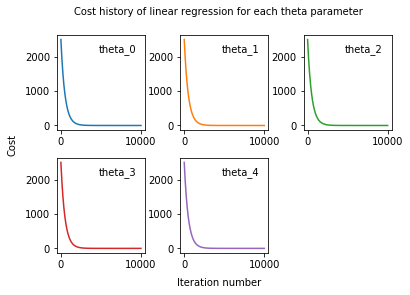

In [7]:
#plot cost history, each theta parameter on a subplots
#with 3 columns
cols = 3
#determine the number of rows
if len(theta) <= 6:
    rows = 2
elif len(facet_names) <= 9:
    rows = 3
else:
    print("Too many parameters")

#generate values for x axis
x_values = [i for i in range(n_iter)]

#get colors for plot lines
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

#draw subplots
fig, ax = plt.subplots(nrows=rows, ncols=cols)
for i in range(len(theta)):
    icol = i % 3
    irow = i // 3
    ax[irow, icol].plot(x_values, history, color=colors[i], label="theta_{}".format(i))
    ax[irow, icol].legend(handlelength=0., frameon=False)
fig.text(0.5, 0.01, "Iteration number", ha="center")
fig.text(0.01, 0.5, "Cost", va="center", rotation="vertical")
fig.text(0.5, 0.95, "Cost history of linear regression for each theta parameter", ha="center")

#adjust distance between subplots
plt.subplots_adjust(hspace=0.3, wspace=0.4)

#delete unused subplots
for i in range(rows*3 -len(theta)):
        fig.delaxes(ax[-1,-(i+1)])
        
plt.show()

The cost converges to a minimum during the chosen number of iterations for each theta parameter. Each convergence has the same shape, which is expected since the features were normalized before gradient descent.
## Normal equation
The normal equation calculates theta in a single step, which prevents us from having to choose a learning rate and going through many iterations during the gradients descent. Another benefit is that there is no need to normalize the data. However, if the sample size is large (> 10,000), calculation using the normal equation may be longer than gradient descent. We first have to add a column of *1* to X to take advantage of vectorized operations.

In [9]:
#add column of ones to X
X_ones = np.concatenate((np.ones((len(data), 1)), X), axis=1)

#calculate theta
theta_norm = norm_eq(X_ones, Y)

#print results
print("\nCalculated theta (gradient descent) :")
for i in range(len(theta_norm)):
    print("theta_",
          i,
          " (",
          param_name[i],
          ") : ",
          format(theta_norm[i].flat[0], '.4f'),
          sep="")


Calculated theta (gradient descent) :
theta_0 (intercept) : 69.4833
theta_1 (Income) : 0.0001
theta_2 (Illiteracy) : 0.2761
theta_3 (Murder) : -0.2619
theta_4 (HS Grad) : 0.0461
